## Check Input & Segmentation Dataset

In [1]:
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import cv2 as cv
import numpy as np
import torch, torchvision
import glob
from torch.utils.data import DataLoader,Dataset
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torchvision import transforms
from Model.Segmentation.ResNetUNet import ResNetUNet
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
from collections import defaultdict

In [2]:
# Check Input Image
input_img = cv.imread('./Dataset/Train/ISIC_0024306.jpg')
i_h, i_w, i_c = input_img.shape

# Check Segmentation Image
output_img = cv.imread('./Dataset/Segmentation_Label/ISIC_0024306_segmentation.png')
o_h, o_w, o_c = output_img.shape

print('Input Image Shape: Width: {}, Height: {}, Channel: {}'.format(i_w, i_h, i_c))
print('Output Image Shape: Width: {}, Height: {}, Channel: {}'.format(o_w, o_h, o_c))

Input Image Shape: Width: 600, Height: 450, Channel: 3
Output Image Shape: Width: 600, Height: 450, Channel: 3


**Input Image**

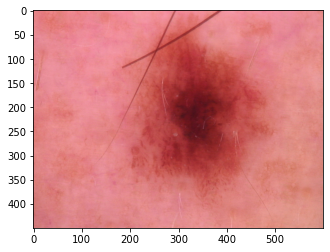

In [3]:
plt.imshow(cv.cvtColor(input_img, cv.COLOR_BGR2RGB))

**Segmentation Image**

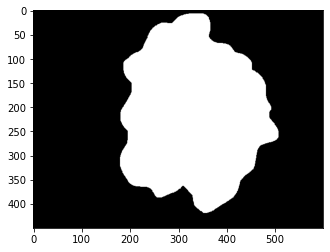

In [4]:
plt.imshow(cv.cvtColor(output_img, cv.COLOR_BGR2RGB))

**Input Image + Segmentation Image**

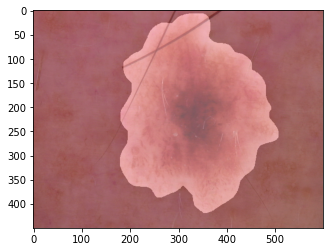

In [5]:
a = 0.7
b = 1-a
dst = cv.addWeighted(input_img, a, output_img, b, 0)
plt.imshow(cv.cvtColor(dst, cv.COLOR_BGR2RGB))

## Make DataLoader

**For Normalization**

In [6]:
def compute_img_mean_std(image_paths):
    """
        computing the mean and std of three channel on the whole dataset,
        first we should normalize the image from 0-255 to 0-1
    """

    img_h, img_w = 224, 224
    imgs = []
    means, stdevs = [], []

    for i in tqdm(range(len(image_paths))):
        img = cv.imread(image_paths[i])
        img = cv.resize(img, (img_h, img_w))
        imgs.append(img)

    imgs = np.stack(imgs, axis=3)
    print(imgs.shape)

    imgs = imgs.astype(np.float32) / 255.

    for i in range(3):
        pixels = imgs[:, :, i, :].ravel()  # resize to one row
        means.append(np.mean(pixels))
        stdevs.append(np.std(pixels))

    means.reverse()  # BGR --> RGB
    stdevs.reverse()

    print("normMean = {}".format(means))
    print("normStd = {}".format(stdevs))
    return means,stdevs

**Check Mean & Std for Normalization**

In [7]:
all_image_path = glob.glob('./Dataset/Images/*.jpg')
# norm_mean,norm_std = compute_img_mean_std(all_image_path)

**Transform**

- Inputsize: 224 -> For Using PreTrain Inception Model

In [8]:
# Define Input Size & Mean, Std
input_size = 224
norm_mean = [0.76304215, 0.5456439, 0.5700431]
norm_std = [0.14092751, 0.15261441, 0.16997588]

# Train Transform
# Input Image Transform
train_transform = transforms.Compose([transforms.Resize((input_size,input_size)),
                                      transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
                                      transforms.ToTensor(), transforms.Normalize(norm_mean, norm_std)])

# Validation & Test Transform
val_transform = transforms.Compose([transforms.Resize((input_size,input_size)),
                                    transforms.ToTensor(), transforms.Normalize(norm_mean, norm_std)])

# Segmentation Image Transorm
seg_transform = transforms.Compose([transforms.Resize((input_size,input_size)),
                                    torchvision.transforms.Grayscale(),
                                    transforms.ToTensor()])

**Segmentation DataLoader**

In [9]:
class Segmentation_Dataset(Dataset):
    def __init__(self, path, img_transform=None, seg_transform=None):
        self.path = path
        self.img_transform = img_transform
        self.seg_transform = seg_transform
        
    def __len__(self):
        return len(self.path)

    def __getitem__(self, index):
        # Load data and segmantation
        file_name = self.path[index].split('/')[-1].split('.')[0]
        img_path = self.path[index]
        seg_path = './Dataset/Segmentation_Label/'+file_name+'_segmentation.png'
        
        X = Image.open(img_path)
        y = Image.open(seg_path)
        # y = np.clip(np.array(y), 0, 1)
        # y = Image.fromarray(y)
        
        # Transform
        if self.img_transform:
            X = self.img_transform(X)
        
        if self.seg_transform:
            y = self.seg_transform(y)
            y[y>0] = 1
            
        return X, y

In [10]:
train_path = glob.glob('./Dataset/Train/*.jpg')
val_path = glob.glob('./Dataset/Val/*.jpg')

# Make DataLoader
# Train
training_set = Segmentation_Dataset(train_path, train_transform, seg_transform)
train_loader = DataLoader(training_set, batch_size=32, shuffle=True, num_workers=4)

# Validation
validation_set = Segmentation_Dataset(val_path, val_transform, seg_transform)
val_loader = DataLoader(validation_set, batch_size=32, shuffle=False, num_workers=4)

# DataLoader
dataloaders = {
    'train': train_loader,
    'val': val_loader
}

**Check DataLoader Data & Segmentation**

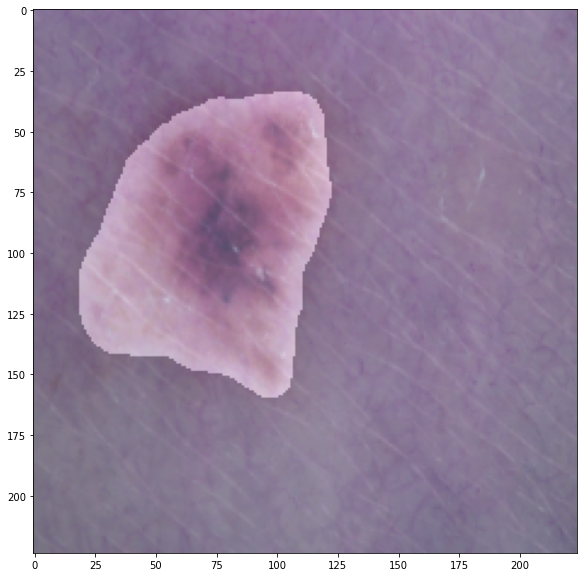

In [11]:
dataiter = iter(train_loader)
img, seg = dataiter.next()

# For Visualization
vis_img = img[0].permute(1,2,0).numpy()
vis_img = (vis_img - np.min(vis_img))/np.ptp(vis_img)
vis_img *= 255/vis_img.max()
vis_img = np.uint8(vis_img)

seg_img = seg[0].numpy()
seg_img = (seg_img - np.min(seg_img))/np.ptp(seg_img)
seg_img *= 255/seg_img.max()

seg_img2 = np.zeros_like(vis_img)
seg_img2[:,:,0] = seg_img
seg_img2[:,:,1] = seg_img
seg_img2[:,:,2] = seg_img
seg_img2 = np.uint8(seg_img2)

dst = cv.addWeighted(vis_img, a, seg_img2, b, 0)

plt.figure(figsize=(20, 10))
plt.imshow(dst)

## Segmentation Model - ResNetUNet
- code: https://github.com/usuyama/pytorch-unet

**Load Inf-Net Segmentation Model**

In [12]:
# Define Model
summary(ResNetUNet(n_class = 1).cuda(), (3, input_size, input_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
            Conv2d-5         [-1, 64, 112, 112]           9,408
            Conv2d-6         [-1, 64, 112, 112]           9,408
       BatchNorm2d-7         [-1, 64, 112, 112]             128
       BatchNorm2d-8         [-1, 64, 112, 112]             128
              ReLU-9         [-1, 64, 112, 112]               0
             ReLU-10         [-1, 64, 112, 112]               0
        MaxPool2d-11           [-1, 64, 56, 56]               0
        MaxPool2d-12           [-1, 64, 56, 56]               0
           Conv2d-13           [-1, 64, 56, 56]          36,864
           Conv2d-14           [-1, 64,

## Train Model

**Loss Function**

In [13]:
def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()

def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)

    pred = torch.sigmoid(pred)
    dice = dice_loss(pred, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)

    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

    return loss

**Check Metric**

In [14]:
def print_metrics(metrics, epoch_samples, phase):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

    print("{}: {}".format(phase, ", ".join(outputs)))

**Train Model**

In [15]:
def train_model(model, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                if epoch !=0:
                    scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])

                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), './PreTrainModel/seg_model.pt')

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Model Train

In [21]:
"""
device = torch.device('cuda:7' if torch.cuda.is_available() else 'cpu')
model = ResNetUNet(n_class = 1).to(device)
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=30, gamma=0.1)
model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=60)
"""

"\ndevice = torch.device('cuda:7' if torch.cuda.is_available() else 'cpu')\nmodel = ResNetUNet(n_class = 1).to(device)\noptimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)\nexp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=30, gamma=0.1)\nmodel = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=60)\n"

## Model Test

**Don't Use Pretrain Model**

In [26]:
device = torch.device('cuda:7' if torch.cuda.is_available() else 'cpu')

# Test Dataset
test_path = glob.glob('./Dataset/Test/*.jpg')
test_set = Segmentation_Dataset(test_path, val_transform, seg_transform)
test_loader = DataLoader(validation_set, batch_size=32, shuffle=False, num_workers=4)

# No PreTrain Model
model = ResNetUNet(n_class = 1).to(device)
total_loss = 0

for inputs, labels in test_loader:
    with torch.set_grad_enabled(False):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = F.binary_cross_entropy_with_logits(outputs, labels)
        total_loss+=loss

In [27]:
print(total_loss/len(test_loader))

tensor(0.6904, device='cuda:7')


**Use Pretrain Model**

In [28]:
# No PreTrain Model
model = ResNetUNet(n_class = 1).to(device)
model.load_state_dict(torch.load('./PreTrainModel/seg_model.pt'))
total_loss = 0

for inputs, labels in test_loader:
    with torch.set_grad_enabled(False):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = F.binary_cross_entropy_with_logits(outputs, labels)
        total_loss+=loss

In [29]:
print(total_loss/len(test_loader))

tensor(0.1124, device='cuda:7')
